In [ ]:
import torch
import numpy as np
import cv2
import albumentations as A

from transformers import SamModel, SamProcessor
from diffusers import StableDiffusionInpaintPipeline, StableDiffusionXLPipeline, StableDiffusionControlNetPipeline, StableDiffusionPipeline, StableDiffusionControlNetImg2ImgPipeline, StableDiffusionXLImg2ImgPipeline, StableDiffusionImg2ImgPipeline, DDIMScheduler, DDIMInverseScheduler, StableDiffusionDiffEditPipeline, StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image, make_image_grid
from PIL import Image, ImageFilter

stable_diffusion_2_inpainting = "stabilityai/stable-diffusion-2-inpainting"
stable_diffusion_refiner =  "stabilityai/stable-diffusion-xl-refiner-1.0"
stable_diffusion_2 = "stabilityai/stable-diffusion-2-1"
stable_diffusion_xl = "stabilityai/stable-diffusion-xl-base-1.0"
sam_model_name = "facebook/sam-vit-base"

cuda = "cuda"
cpu = "cpu"

In [ ]:
sam_processor = SamProcessor.from_pretrained(sam_model_name)
sam_model = SamModel.from_pretrained(sam_model_name)
sam_model = sam_model.to(cuda)

print("SAM loaded")

In [ ]:
stable_inpainting_pipe = StableDiffusionInpaintPipeline.from_pretrained(stable_diffusion_2, revision='fp16', torch_dtype=torch.float16).to(cpu)
# stable_inpainting_pipe = stable_inpainting_pipe

In [ ]:
stable_refiner_pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(stable_diffusion_refiner, variant="fp16", torch_dtype=torch.float16).to(cpu)
# stable_refiner_pipe = stable_refiner_pipe

In [ ]:
# stable_XL_pipe = StableDiffusionXLPipeline.from_pretrained(stable_diffusion_xl, torch_dtype=torch.float16, variant="fp16", use_safetensors=True).to(cuda)

In [ ]:
stable_text_to_image_pipe = StableDiffusionPipeline.from_pretrained(stable_diffusion_2, torch_dtype=torch.float16).to(cpu)
# stable_text_to_image_pipe = stable_text_to_image_pipe.to(cuda)

In [ ]:
# stable_img_2_img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_t2i, revision='fp16', torch_dtype=torch.float16)
# stable_img_2_img_pipe = stable_img_2_img_pipe.to(cpu)

### Image processing utilities

In [ ]:
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline
def read_image(filename):
    return Image.open("./Image-Gen/images/" + filename).convert("RGB")

def download_image(url, _format="RGB"):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert(_format)

def expand2square(pil_img, background_color=[255, 255, 255]):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        # result = Image.new(pil_img.mode, (width, width), tuple(background_color))
        if pil_img.mode == 'RGBA':
            result = Image.new(pil_img.mode, (width, width), tuple(background_color + [0]))
            result.putalpha(0)
        else:
            result = Image.new(pil_img.mode, (width, width), tuple(background_color))
        
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        if pil_img.mode == 'RGBA':
            result = Image.new(pil_img.mode, (height, height), tuple(background_color + [0]))
            result.putalpha(0)
        else:
            result = Image.new(pil_img.mode, (height, height), tuple(background_color))

        result.paste(pil_img, ((height - width) // 2, 0))
        return result
    
def to_image(img_array):
    return Image.fromarray(img_array)

def get_mask(image, delta=20, num_centers = 3):
    global sam_model
    result = []

    assert num_centers%2!=0

    center_point = np.array(image.size)/2
    c_x, c_y = center_point

    lower_value = -(num_centers - 2)
    upper_value = num_centers - 2

    input_points = [[[(c_x, (c_y + i*delta))] for i in range(lower_value, upper_value+1)]]

    input_data = sam_processor(image, input_points=input_points, return_tensors="pt")
    input_data = input_data.to(cuda)
    sam_model = sam_model.to(cuda)

    with torch.no_grad():
        prediction_output = sam_model(**input_data)
        
        prediction_output = sam_processor.image_processor.post_process_masks(
            prediction_output.pred_masks.cpu(), 
            input_data["original_sizes"].cpu(), 
            input_data["reshaped_input_sizes"].cpu()
        )
        
        if torch.cuda.is_available():
            # Empty the GPU cache and collect garbage
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()

    outputs = prediction_output[0]
    outputs = np.transpose(outputs.numpy(), [0, 2, 3, 1]).astype(np.uint8) * 255
    mask = np.sum(outputs, axis=0)

    sam_model = sam_model.to(cpu)

    return mask, outputs
    # return Image.fromarray(masks)

def find_contour(image):
    """
    Finds contours in the given image.

    Args:
        image (numpy.ndarray): The input image.

    Returns:
        tuple: A tuple containing the contours and the thresholded image.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply binary thresholding
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]
    # Return the contours
    return contours, thresh

def get_centroid(contour):
    """
    Calculates the centroid of a contour.

    Args:
        contour (numpy.ndarray): The input contour.

    Returns:
        tuple: A tuple containing the centroid coordinates (x, y).
    """
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        cx = 0
        cy = 0
    return cx, cy

def add_padding(image):
    width, height = image.size
    size = max(width, height)
    new_width = size + 40
    new_height = size + 40
    padding = (20, 20, 20, 20)  # (left, top, right, bottom)
    padded_image = Image.new('RGB', (new_width, new_height), (255, 255, 255))
    padded_image.paste(image, ((new_width - width) // 2, (new_height - height) // 2))
    return padded_image

def remove_white_border(image):
    # Convert the image to grayscale
    gray_image = image.convert("L")
    
    # Get the dimensions of the image
    width, height = gray_image.size
    
    # Define the border color
    border_color = 255  # White
    
    # Check if the top border is white
    top_border = True
    for x in range(width):
        if gray_image.getpixel((x, 0)) != border_color:
            top_border = False
            break
    
    # Check if the bottom border is white
    bottom_border = True
    for x in range(width):
        if gray_image.getpixel((x, height - 1)) != border_color:
            bottom_border = False
            break
    
    # Check if the left border is white
    left_border = True
    for y in range(height):
        if gray_image.getpixel((0, y)) != border_color:
            left_border = False
            break
    
    # Check if the right border is white
    right_border = True
    for y in range(height):
        if gray_image.getpixel((width - 1, y)) != border_color:
            right_border = False
            break
    
    # Calculate the new dimensions of the image
    new_width = width
    new_height = height
    if top_border:
        new_height -= 20
    if bottom_border:
        new_height -= 20
    if left_border:
        new_width -= 20
    if right_border:
        new_width -= 20
    
    # Crop the image to remove the white border
    cropped_image = image.crop((20, 20, new_width, new_height))
    
    return cropped_image


def insert_logo(image, logo_path, position='left', logo_size=(50, 50), padding=50):
    # Open the logo image
    if type(logo_path) == str:
        logo = Image.open(logo_path)
    else:
        logo = logo_path
    
    # Resize the logo image
    logo = expand2square(logo)
    logo = logo.resize(logo_size)
    
    # Convert the image to RGBA mode
    # image = image.convert("RGBA")
    
    # Calculate the position to insert the logo
    if position == 'left':
        x = padding
        y = padding
    elif position == 'right':
        x = image.width - logo.width - padding
        y = padding
    else:
        raise ValueError("Invalid position. Position must be 'left' or 'right'.")
    
    # Paste the logo onto the image
    image.paste(logo, (x, y), mask=logo)
    
    return image

def insert_cropped_image(generate_image, init_image, anti_mask):
    # Convert the anti_mask to grayscale
    anti_mask_gray = anti_mask.convert("L")
    
    # Invert the anti_mask
    inverted_anti_mask = Image.eval(anti_mask_gray, lambda x: 255 - x)
    
    # Apply the anti_mask to the init_image
    cropped_image = Image.composite(init_image, generate_image, inverted_anti_mask)
    
    # Convert the cropped_image to RGBA mode
    cropped_image_rgba = cropped_image.convert("RGBA")
    
    # Create a blank image with the same size as generate_image
    result_image = Image.new("RGBA", generate_image.size)
    
    # Paste the cropped_image onto the result_image
    result_image.paste(cropped_image_rgba, (0, 0), mask=cropped_image_rgba)
    
    return result_image.convert("RGB")


transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0, scale_limit=(-0.4, -0.4), rotate_limit=0, p=1, border_mode=1, interpolation=4,
                       shift_limit_y=[0.1, 0.25])
])

### Download image

In [448]:
image_urls = [
    "https://in-media.apjonlinecdn.com/catalog/product/cache/b3b166914d87ce343d4dc5ec5117b502/c/0/c08510542_1_1_1.png",
    "https://gynoveda.com/cdn/shop/products/Myhra_Veerha_carousel_V2_720x.jpg?v=1676550513",
    "https://gynoveda.com/cdn/shop/files/EDIT_1_GynV_Fertility_Carousel_76b2bd8e-f7a5-4ab0-8997-e84d4809e95e_720x.jpg?v=1686565762",
    "https://gynoveda.com/cdn/shop/files/SOMHA_Cover_720x.jpg?v=1686732933",
    "https://cdn.motor1.com/images/mgl/NGOMej/s1/bmw-i5-edrive40-2023.webp",
    "https://www.bmw-me.com/content/dam/bmw/common/all-models/m-series/series-overview/bmw-m-series-seo-overview-ms-04.jpg",
    "https://i1.adis.ws/i/canon/maxify-gx7050-ambient-reception-03_1920x1080-66d4a17cd389?w=100%&sm=aspect&aspect=16:9&qlt=100&scaleFit=poi&poi=0.4375,0.3888888888888889,0.125,0.2222222222222222&fmt=jpg&fmt.options=interlaced&bg=rgb(255,255,255)"
]

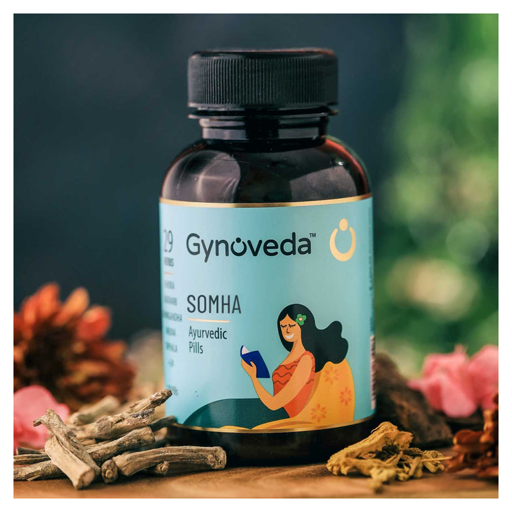

In [490]:
img_url = image_urls[3]


init_image = download_image(img_url)
# init_image = vedant
init_image = expand2square(init_image)
init_image = add_padding(init_image)
init_image = init_image.resize((512, 512))
init_image

### generate prompt strings

In [472]:
bg_elements = [
    "table",
    "placed on table",
    "christmas",
    "christmas tree",
    "dark color palet",
    # "santa",
    "gifts",
    "city",
    # "road"
    "realistic",
    "high res",
    "8k",
    "cinematic",
    "soft lighting",
    "winter"
]

fg_elements = [
    # "christmas tree",
    # "gifts",
    # "road"
    "table",
    "placed on table"
    # "christmas theme",
    # "christmas gifts",
    # "realistic",
    # "high res",
    # "remove white border",
    # "8k",
    # "cinematic",
]

elements = [
    "christmas theme",
    "christmas lights",
    "christmas decorations",
    "good shadows",
    "good lighting",
    "realistic",
    "high res",
    "remove white border",
    "8k",
    "cinematic"]

negative_elements = [
    "bad contrast",
    "light color palate",
    "white border",
    "no car",
    "photo frames",
    "multiple images",
    "bright colors",
    "many cars",
    "thick white border",
    "bad quality",
    "cartoony",
    "longbody",
    "lowres",
    "bad anatomy",
    "bad hands",
    "missing fingers",
    "extra digit",
    "fewer digits",
    "cropped",
    "worst quality",
    'low quality',
    'letters',
    "miss-matched lighting",
    "miss-matched shadows",
    "altered the original subject"
]

bg_prompt = ", ".join(bg_elements)
# bg_prompt = "still, night city road"
fg_prompt = ", ".join(fg_elements)
prompt = ", ".join(elements)
negative_prompt = ", ".join(negative_elements)

dims = 512
height, width = dims, dims

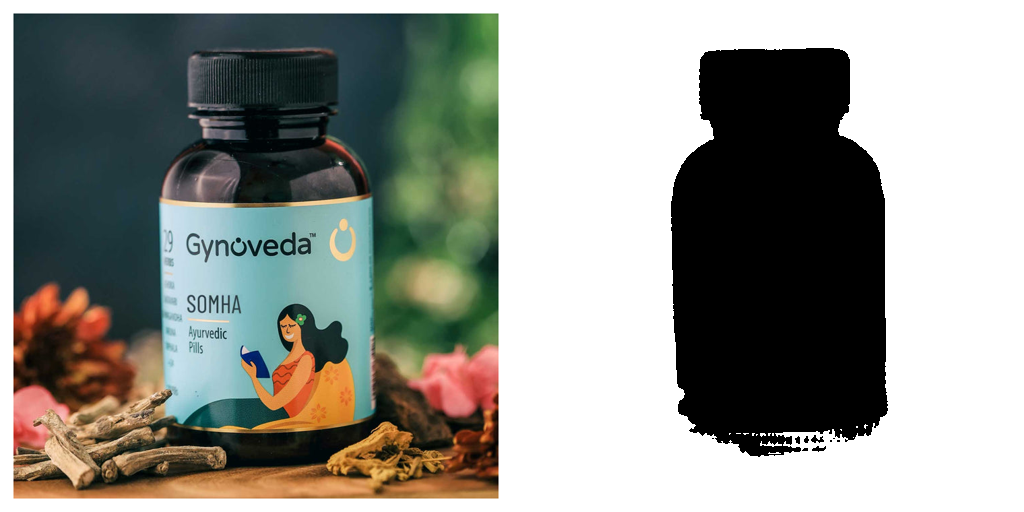

In [491]:
mask, mask_items = get_mask(init_image, 10, 3)
mask_image = sum(mask_items)
# Convert the PIL.Image object to a numpy array
mask_array = np.array(mask_image)

# Find the indices where the colors are not white
non_black_indices = np.where(np.any(mask_array != 0, axis=-1))

# Set the non-white spots to white and everything else to black
mask_array_normalized = mask_array.copy()
mask_array_normalized[non_black_indices] = [255, 255, 255]
# mask_array[np.logical_not(non_white_indices)] = [0, 0, 0]

# Convert the numpy array back to a PIL.Image object
converted_mask_image = Image.fromarray(mask_array_normalized)
anti_mask = Image.fromarray(255 - np.array(converted_mask_image))#.filter(ImageFilter.GaussianBlur(8))

input_image = init_image
input_mask = anti_mask#.filter(ImageFilter.GaussianBlur(2))

display(make_image_grid([input_image, input_mask], 1, 2))

transformed_image_mask = transform(image=np.array(input_image), mask=np.array(input_mask))

input_image = to_image(transformed_image_mask['image'])
input_mask = to_image(transformed_image_mask['mask'])

### generate background

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

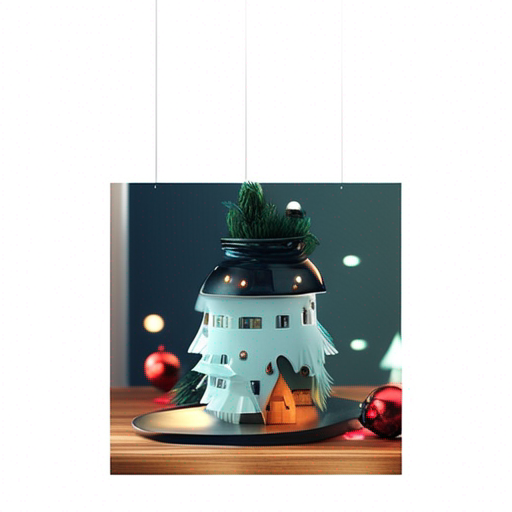

In [493]:
# prompt_bg = "Streets with chrimas theme decoration, showing that it is chrismas time and there its beautiful and snowy"
with torch.no_grad():
    stable_inpainting_pipe = stable_inpainting_pipe.to(cuda)
    stable_refiner_pipe = stable_refiner_pipe.to(cuda)

    image_bg = stable_inpainting_pipe(prompt=bg_prompt, image=input_image, mask_image=input_mask, negative_prompt=negative_prompt, guidance_scale=8.5, num_inference_steps=100, strength=0.7, height=height, width=width).images[0]
    image_bg = stable_refiner_pipe(prompt=bg_prompt, image=image_bg, height=height, width=width, negative_prompt=negative_prompt).images[0]
    
    stable_text_to_image_pipe = stable_text_to_image_pipe.to(cpu)
    stable_refiner_pipe = stable_refiner_pipe.to(cpu)

image_bg

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

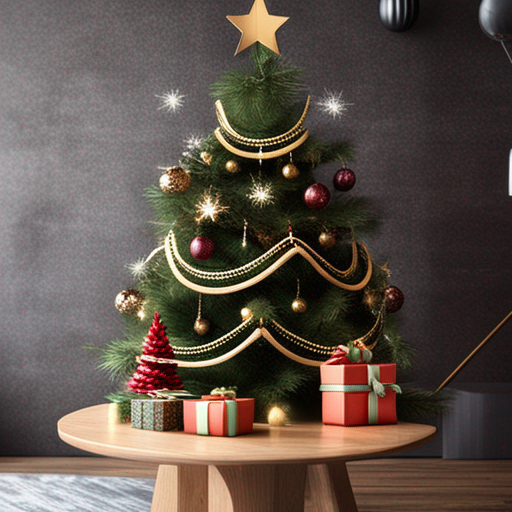

In [494]:
# prompt_bg = "Streets with chrimas theme decoration, showing that it is chrismas time and there its beautiful and snowy"
with torch.no_grad():
    stable_text_to_image_pipe = stable_text_to_image_pipe.to(cuda)
    stable_refiner_pipe = stable_refiner_pipe.to(cuda)

    image_bg = stable_text_to_image_pipe(prompt=bg_prompt, negative_prompt=negative_prompt, guidance_scale=10, height=height, width=width).images[0]
    image_bg = stable_refiner_pipe(prompt=bg_prompt, image=image_bg, height=height, width=width, negative_prompt=negative_prompt).images[0]
    
    stable_text_to_image_pipe = stable_text_to_image_pipe.to(cpu)
    stable_refiner_pipe = stable_refiner_pipe.to(cpu)

image_bg

### extract mask

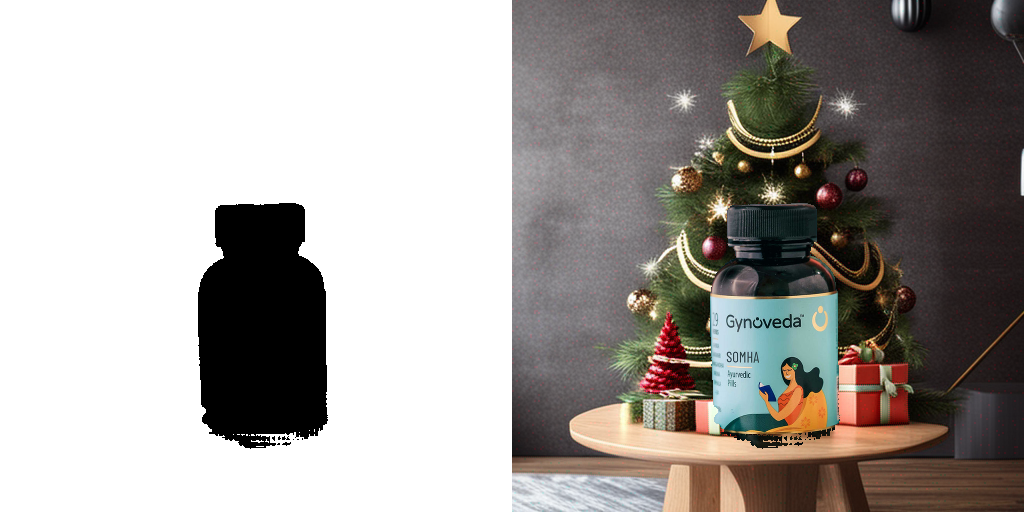

In [495]:

image_np = np.array(image_bg)
idx = np.where(np.array(input_mask) == 0)
image_np[idx[0], idx[1], :] = np.array(input_image)[idx[0], idx[1], :]

input_image = image_np

display(make_image_grid([input_mask, to_image(image_np)], 1, 2))

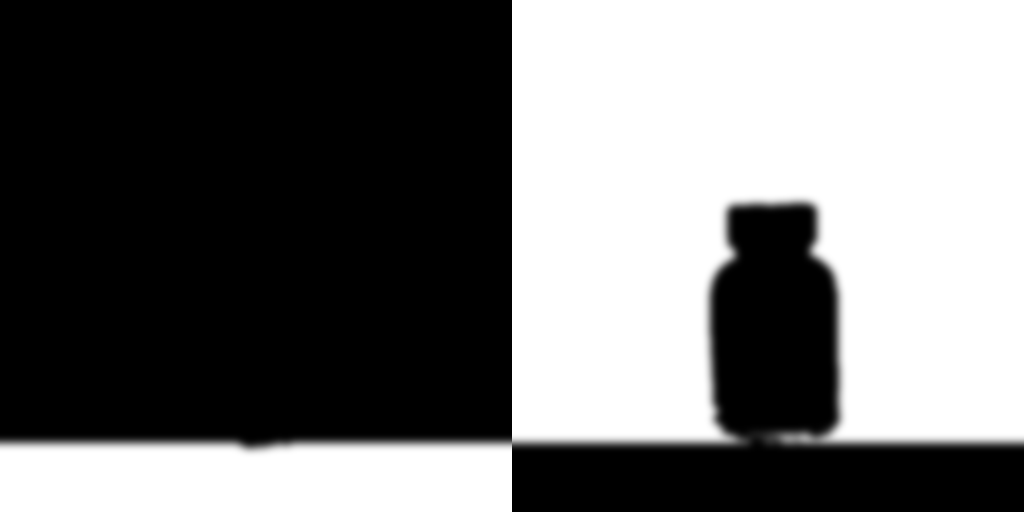

In [497]:
# Find the contours and centroid of the mask
input_mask_array = np.array(input_mask)
input_image_array = np.array(input_image)

contours, ret = find_contour(input_mask_array)
cx, cy = get_centroid(contours[0])
max_min_cy = (contours[0][:, 0, 1].max() - contours[0][:, 0, 1].min()) // 3

anchor_point = int(np.random.uniform(0, max_min_cy))
anti_mask = np.copy(input_mask)
anti_mask[(cy - anchor_point):, :, :] = 0
anti_mask_lower = (input_mask - anti_mask)
anti_mask_lower = to_image(anti_mask_lower).filter(ImageFilter.GaussianBlur(4))

anti_mask = np.copy(input_mask_array)
anti_mask[:(cy - anchor_point), :] = 0
anti_mask_upper = 255 - (input_mask_array - anti_mask)
anti_mask_upper = Image.fromarray(255 - anti_mask_upper).filter(ImageFilter.GaussianBlur(4))
new_mask_ori = Image.fromarray(input_mask_array)
new_mask = new_mask_ori.filter(ImageFilter.GaussianBlur(8))

make_image_grid([anti_mask_lower, anti_mask_upper, ], 1, 2)

In [498]:
image_fr = to_image(input_image)

prompt_lower = "road aligned with the car, city, christmas theme, darker colors, fill the white space" + bg_prompt

stable_inpainting_pipe = stable_inpainting_pipe.to(cuda)
stable_refiner_pipe = stable_refiner_pipe.to(cuda)

image_fr = stable_inpainting_pipe(
    prompt=prompt_lower,
    negative_prompt=negative_prompt,
    image=image_fr,
    mask_image=anti_mask_lower,
    num_inference_steps=100,
    guidance_scale=8.5,
    strength=0.5,
    height=height,
    width=width
).images[0]

image_fr = stable_refiner_pipe(
    prompt=prompt_lower,
    image=image_fr,
    height=height,
    width=width
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

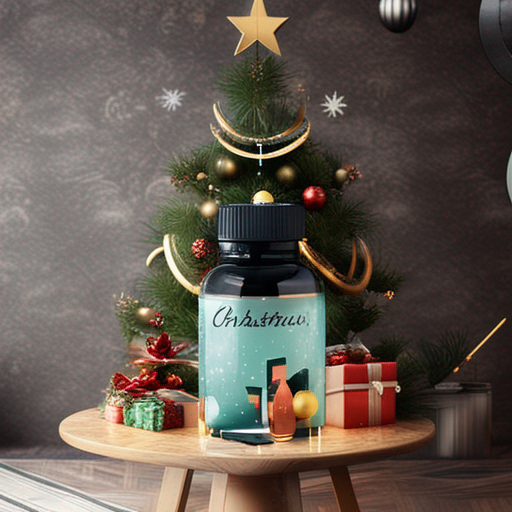

In [499]:
image_fr

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

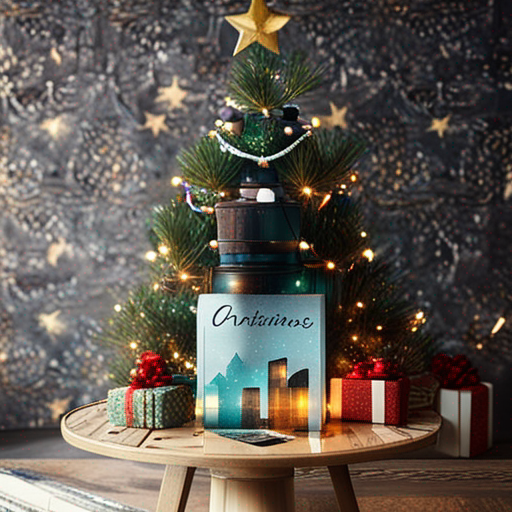

In [500]:
# image_fr = to_image(input_image)

# prompt_lower = "road, city, christmas theme, darker colors, " + bg_prompt

# stable_inpainting_pipe = stable_inpainting_pipe.to(cuda)
# stable_refiner_pipe = stable_refiner_pipe.to(cuda)

# image_fr = stable_inpainting_pipe(
#     prompt=prompt_lower,
#     negative_prompt=negative_prompt,
#     image=image_fr,
#     mask_image=anti_mask_lower,
#     num_inference_steps=50,
#     guidance_scale=8.5,
#     height=height,
#     width=width
# ).images[0]

# image_fr = stable_refiner_pipe(
#     prompt=prompt_lower,
#     image=image_fr,
#     height=height,
#     width=width
# ).images[0]

image_fr = stable_inpainting_pipe(
    prompt=bg_prompt,
    image=image_fr,
    mask_image=anti_mask_upper,
    num_inference_steps=100,
    guidance_scale=8.5,
    strength=0.5,
    negative_prompt=negative_prompt,
    height=height,
    width=width
).images[0]

image_fr = stable_refiner_pipe(
    prompt=bg_prompt,
    image=image_fr,
    height=height,
    width=width
).images[0]

stable_inpainting_pipe = stable_inpainting_pipe.to(cpu)
stable_refiner_pipe = stable_refiner_pipe.to(cpu)

image_fr

In [ ]:
scale = (1 - np.array(new_mask)/255)*(1 - np.array(new_mask)/255)
image_np = scale*transformed_image_mask["image"] + (1 - scale)*image_fr
output_scaling = to_image(image_np.astype(np.uint8))
output_scaling


### Object pasting

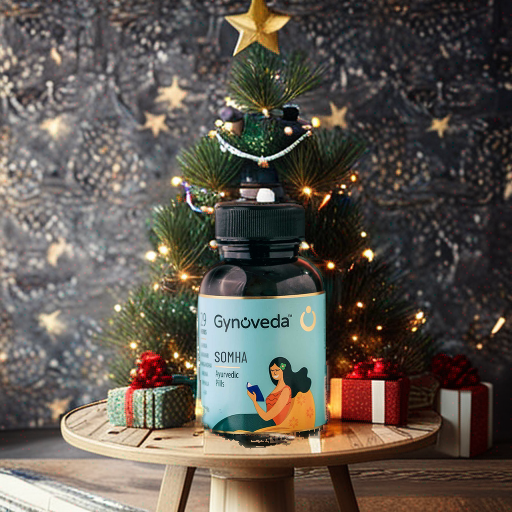

In [501]:
output_pasting = insert_cropped_image(image_fr, to_image(input_image), input_mask.filter(ImageFilter.GaussianBlur(2)))
output_pasting

In [ ]:
merged_images = make_image_grid([output_pasting, output_scaling], 1, 2)
merged_images.convert("RGB").save("test.jpg")

### Full masking

In [ ]:
elements = [
    "table",
    "christmas theme",
    "christmas gifts",
    "aligned with the subject",
    # "good shadows",
    # "good lighting",
    "realistic",
    "high res",
    "remove white border",
    "8k",
    "cinematic",
]

prompt = ", ".join(elements)

In [ ]:
stable_text_to_image_pipe = stable_text_to_image_pipe.to(cuda)
stable_refiner_pipe = stable_refiner_pipe.to(cuda)

image = stable_inpainting_pipe(
    prompt=prompt,
    image=input_image,
    mask_image=input_mask,
    num_inference_steps=50,
    guidance_scale=8.5,
    negative_prompt=negative_prompt,
    height=height,
    width=width
).images[0]

image = stable_refiner_pipe(
    prompt=prompt,
    image=image,
    negative_prompt=negative_prompt,
    height=height,
    width=width
).images[0]

stable_text_to_image_pipe = stable_text_to_image_pipe.to(cpu)
stable_refiner_pipe = stable_refiner_pipe.to(cpu)

image

In [ ]:
elements = [
    "car in focus",
    "car driving downtown city roads",
    "night life",
    "big city like NYC",
    "christmas theme background",
    "christmas lights",
    "christmas decorations",
    "good shadows",
    "good lighting",
    "realistic",
    "high res",
    "remove white border",
    "8k",
    "cinematic"]

negative_elements = [
    "thick white border",
    "bad quality",
    "cartoony",
    "longbody",
    "lowres",
    "bad anatomy",
    "bad hands",
    "missing fingers",
    "extra digit",
    "fewer digits",
    "cropped",
    "worst quality",
    'low quality',
    'letters',
    "miss-matched lighting",
    "miss-matched shadows",
    "altered the original subject"
]

# "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, letters" 

prompt = ", ".join(elements)
negative_prompt = ", ".join(negative_elements)

with torch.no_grad():
    print("prompt:", prompt)
    print("negative prompt:", negative_prompt)

    stable_inpainting_pipe = stable_inpainting_pipe.to(cuda)
    stable_refiner_pipe = stable_refiner_pipe.to(cuda)

    image = stable_inpainting_pipe(
        prompt=prompt, 
        image=input_image, 
        mask_image=input_mask, 
        num_inference_steps=100,
        negative_prompt=negative_prompt,
        guidance_scale=7,
        strength=0.7,
        width=512,
        height=512).images[0]
    
    
    refined_image = stable_refiner_pipe(
        prompt=prompt, 
        image=image, 
        num_inference_steps=50,
        strength=0.3,
        negative_prompt=negative_prompt,
        width=512,
        height=512).images[0]
    
    stable_inpainting_pipe = stable_inpainting_pipe.to(cpu)
    stable_refiner_pipe = stable_refiner_pipe.to(cpu)

    print("Done 👍")

### Logo insertion

In [ ]:
logo = download_image("https://www.pngall.com/wp-content/uploads/13/HP-Logo-PNG-Pic.png", "RGBA")
# logo = download_image("https://lh3.googleusercontent.com/czOeSYUKgDH0kDg12maqD7tDKBUhpTUZkSQYFSjIkHVDfkhr2OsipUj-jpZx_reiVs_oZ_OdRosEUsxPctIlnM1AGzperD-u1w=s0", "RGBA")
img = output_pasting
insert_logo(img, logo, logo_size=(100, 100), padding=10)

In [ ]:
image = insert_cropped_image(refined_image, input_image, input_mask)
image


In [ ]:
input_mask